In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys
import os
sys.path.append(os.environ["LATENT_PATH"])
import pickle
from auto_localization.experiment_management.basic_experiment import BasicExperiment
from auto_localization.dataset_management.data_manager import DataManager
from datasets.morpho_mnist.dataset import ImageDataset, TripletDataset, MetadataDataset
from auto_localization.oracles.metadata_oracle import MetadataOracle
from auto_localization.oracles.indexed_metadata_oracle import IndexedMetadataOracle
from auto_localization.oracles.indexed_class_oracle import IndexedClassOracle
from datasets.morpho_mnist.measure import measure_image
from auto_localization.models.loss.masked_vae_triplet_loss import MaskedVAETripletLoss
import auto_localization.models.loss.bayesian_triplet_loss as btl
from tqdm import tqdm
from torch.distributions.normal import Normal
import matplotlib
import seaborn as sns
import scipy.stats
%matplotlib inline

## High Level Plan
1. Compute the true probability of selecting the anchor given a positive and negative.
    1. This can be calculated using the Triplet Likelihood function from the Bayesian Triplet Loss Paper
2. We want to estimate the certainty (closeness to 0 or 1) of this probability using only the positive and negative distribution.
    1. The reason we want to do this is so that we can alter the probability that we give our MCMC Bayesian inference procedure.
    2. Currently we are giving Stan a probability that is computed using a global noise constant k
    3. This means we cannot independently model the expected amount of information content of each query. 
    4. Accurately estimating the amount of noise or inversely the amount of information content in a query is vital for efficient and correct localizaition.
3. We need to make some system for inferring the amount of certainty and measure the error compared to the true probability/certainty of selecting an anchor.
4. If we can do this we can compare this to the amount of certainty inferred by the logistic response model. 
    1. This can be done by recording the probabilities given to MCMC and comparing them to the true probabilities. 
5. If the experiments up until this point are fruitful then we should test with an actual localization run. 

## Helper Code

Load a relevant Bayesian Triplet Loss Model

In [24]:
# load a traditional model
run_name = "silvery-music-271"
# load up the experiment parameters from the given run_name
run_directory = os.path.join(os.environ["LATENT_PATH"], "auto_localization", "logs", run_name)
# load the expeirment config
params_path = run_directory + "/params.pkl"
with open(params_path, "rb") as f:
    experiment_config = pickle.load(f)
# make the experiment
basic_experiment = BasicExperiment(experiment_config=experiment_config, do_setup=False)
basic_experiment.load_data(run_directory)
# get the model
model = basic_experiment.model

Setting Up Logging


wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Setup Model Config
Setting Up Model
MaskedVAE(
  (loss_function): BayesianTripletLoss(margin=0.0000)
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=4, bias=True)
  (fc2): Linear(in_features=1024, out_features=4, bias=True)
  (d1): Linear(in_features=4, out_features=1024, bias=True)
  (deconv2): ConvTranspose2d(

Setup dataset

In [25]:
# setup tripelt dataset
which_digits=[1]
component_weighting = [1.0, 0.0, 1.0, 1.0, 1.0, 0.0]
one_two_ratio = 0.0
attribute_return = True

metadata_dataset = MetadataDataset(
    train=True, 
    which_digits=which_digits
)
metadata_oracle = IndexedMetadataOracle(
    metadata_dataset=metadata_dataset,
    component_weighting=component_weighting,
)

image_train = ImageDataset(train=True)

# setup data manager
triplet_train_dataset = TripletDataset(
    train=True,
    which_digits=which_digits,
    oracle=metadata_oracle,
    one_two_ratio=one_two_ratio,
    attribute_return=attribute_return, 
    single_feature_triplet=True
) 
triplet_test_dataset = TripletDataset(
    train=False,
    which_digits=which_digits,
    oracle=metadata_oracle,
    one_two_ratio=one_two_ratio,
    attribute_return=attribute_return, 
    single_feature_triplet=True
) 

Calculate the mean and latent variance of a bunch of triplets.

In [26]:
# measure of whether or not a query is satisfied by a model
def triplet_forward(model, triplet):
    anchor, positive, negative, attribute_index = triplet
    anchor_mu, anchor_logvar, anchor_z, _ = model.forward(anchor.cuda())
    positive_mu, positive_logvar, positive_z, _ = model.forward(positive.cuda())
    negative_mu, negative_logvar, negative_z, _ = model.forward(negative.cuda())
    
    return ([anchor_mu, anchor_logvar], [positive_mu, positive_logvar], [negative_mu, negative_logvar], attribute_index)

In [27]:
num_triplets = 500
triplets = []
for triplet_index in tqdm(range(num_triplets)):
    triplet, _ = triplet_train_dataset[triplet_index]
    triplet_out = triplet_forward(model, triplet)
    triplets.append(triplet_out)    

100%|██████████| 500/500 [00:04<00:00, 115.86it/s]


## True Probability of Selecting an Anchor

Implement the triplet likelihood function from the Bayesian Triplet Loss paper

In [29]:
"""
    This calculates the mean and variance of Tau given a triplet
"""
def get_nll_mean_variance(triplet_out):
    A, P, N, attribute_index = triplet_out
    (muA, varA) = A
    (muP, varP) = P
    (muN, varN) = N
    varA = varA.exp()
    varP = varP.exp()
    varN = varP.exp()
    nll_variance, nll_mean = btl.get_ll_mean_variance(muA, muP, muN, varA, varP, varN, margin = 0.0)
    return nll_mean, nll_variance

"""
    This computes the cdf of the tau distribution. This amounts to the probability
    that an anchor is the ideal point given an answer to a query. We want this to be 1.0.
"""
def compute_btl_probability(triplet, margin=0.0):
    mu, sigma2 = get_nll_mean_variance(triplet)
    sigma = sigma2**0.5
    probs = Normal(loc=mu, scale=sigma + 1e-8).cdf(margin)
    return probs.item()

def compute_predicted_certainty(triplet, margin=0.0):
    probs = compute_btl_probability(triplet, margin=0.0)
    return abs(probs - 0.5)

For the precalculated triplets compute the probability of selecting the anchor.

In [7]:
probabilities = []
for triplet in triplets:
    probability = compute_btl_probability(model, triplet, margin=0.0)
    probabilities.append(probability)

TypeError: compute_btl_probability() got multiple values for argument 'margin'

Plot the distributon of the probabilities. 

0.815234577357769


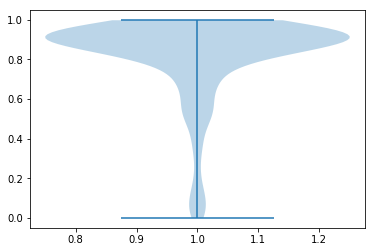

In [46]:
fig, axs = plt.subplots(1, 1)
axs.violinplot(probabilities)
print(np.mean(probabilities))
plt.show()

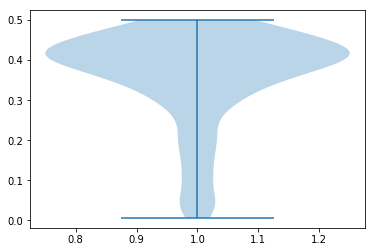

In [48]:
diff_probabilities = np.abs(np.array(probabilities) - 0.5)
fig, axs = plt.subplots(1, 1)
axs.violinplot(diff_probabilities)
plt.show()

## Estimate the Probability Using only the Positive and Negative

Define the estimation method.

In [10]:
"""
    This calculates the mean and variance of Tau given a triplet
"""
def get_nll_mean_variance_std_normal(triplet_out):
    A, P, N, attribute_index = triplet_out
    (muP, varP) = P
    (muN, varN) = N
    varP = varP.exp()
    varN = varP.exp()
    muA = torch.zeros_like(muP)
    varA = torch.ones_like(varP)
    nll_variance, nll_mean = btl.get_ll_mean_variance(muA, muP, muN, varA, varP, varN, margin=0.0)
    return nll_mean, nll_variance

"""
    This computes the cdf of the tau distribution. This can be thought of as the expectation of 
    Tau over the possible locations of the anchor given no information.
"""
def compute_btl_probability_std_normal(triplet, margin=0.0):
    mu, sigma2 = get_nll_mean_variance_std_normal(triplet)
    sigma = sigma2**0.5
    probs = Normal(loc=mu, scale=sigma + 1e-8).cdf(margin)
    return probs.item()

def compute_predicted_certainty(triplet, margin=0.0):
    prob = compute_btl_probability_std_normal(triplet, margin=margin)
    return abs(prob - 0.5)

Compute the Estimated Probabilities

In [23]:
estimated_probabilities = []
for triplet in triplets:
    probability = compute_btl_probability_std_normal(model, triplet, margin=0.0)
    estimated_probabilities.append(probability)

Plot the probabilities

0.7264921889901161


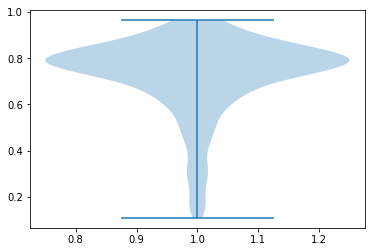

In [47]:
fig, axs = plt.subplots(1, 1)
axs.violinplot(estimated_probabilities)
print(np.mean(estimated_probabilities))
plt.show()

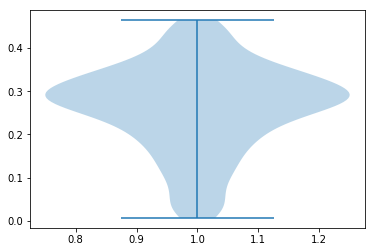

In [49]:
diff_estimated_probabilities = np.abs(np.array(estimated_probabilities) - 0.5)
fig, axs = plt.subplots(1, 1)
axs.violinplot(diff_estimated_probabilities)
plt.show()

Compute the correlation between these probabilities and the other ones. 

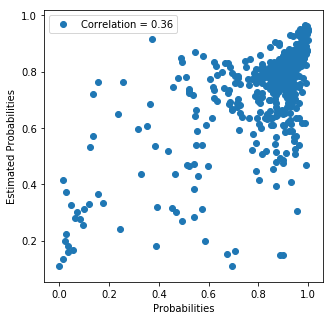

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.scatter(
    probabilities,
    estimated_probabilities,
    label=f'Correlation = {np.round(np.corrcoef(diff_probabilities, diff_estimated_probabilities)[0,1], 2)}'
)
axs.set_xlabel("Probabilities")
axs.set_ylabel("Estimated Probabilities")
plt.legend()
plt.show()

## Compute the Probabilities For the Logistic Response Model

Compute the probabilities using the logistic response model.

In [30]:
from enum import Enum
"""
    Enum of noise constant types
"""
class KNormalizationType(Enum):
    CONSTANT = 0
    NORMALIZED = 1
    DECAYING = 2

def pair2hyperplane(positive_z, negative_z, normalization):
    A_emb = 2*(positive_z - negative_z)
    if np.linalg.norm(A_emb) == 0:
        A_emb = np.ones_like(positive_z)*0.000001
    tau_emb = (np.linalg.norm(positive_z)**2 - np.linalg.norm(negative_z)**2)
    if normalization is KNormalizationType.CONSTANT:
        pass
    elif normalization is KNormalizationType.NORMALIZED:
        A_mag = np.linalg.norm(A_emb)
        A_emb = A_emb / A_mag
        tau_emb = tau_emb / A_mag
    elif normalization is KNormalizationType.DECAYING:
        A_mag = np.linalg.norm(A_emb)
        A_emb = A_emb * np.exp(-A_mag)
        tau_emb = tau_emb * np.exp(-A_mag)
    
    return (A_emb, tau_emb)

def calculate_logistic_probability(anchor_z, positive_z, negative_z, k=1.0, normalization=KNormalizationType.CONSTANT):
    anchor_z = anchor_z.detach().cpu().numpy()
    positive_z = positive_z.detach().cpu().numpy()
    negative_z = negative_z.detach().cpu().numpy()
    def logistic_function(val):
        return 1 / (1 + np.exp(-val))
    
    A_emb, tau_emb = pair2hyperplane(positive_z, negative_z, normalization=normalization)
    probability = logistic_function(k *
        (np.dot(A_emb, anchor_z) - tau_emb)
    )
    return probability


/home/alec/anaconda3/envs/latent/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


[0.7221392765498558, 0.7229819254095003, 0.7236190480267768, 0.7240619241485466, 0.7243231063665269, 0.7244374778227557, 0.7244563822303751, 0.7244250956502246, 0.7243681434168077, 0.724292809821445, 0.7242034507376625, 0.7241128373913646, 0.7240403638735797, 0.7239991900794168, 0.723986834510579, 0.723989773134712, 0.7239954519908892, 0.723998714114488, 0.7239997741891698, 0.7239999771161698, 0.7239999988033681, 0.7239999999722811, 0.7239999999997673, 0.7239999999999994, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724, 0.724]


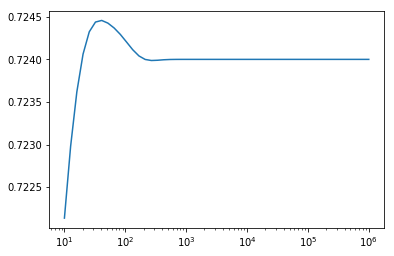

In [31]:
ks = list(np.logspace(1, 6, num=50))
probs = []
for k in ks:
    logistic_probabilities = []
    for triplet in triplets:
        A, P, N, attribute_index = triplet
        A, _ = A
        P, _ = P
        N, _ = N
        A = A.squeeze()
        P = P.squeeze()
        N = N.squeeze()
        probability = calculate_logistic_probability(A, P, N, k=k)
        logistic_probabilities.append(probability)
    probs.append(np.mean(logistic_probabilities))

fig, axs = plt.subplots(1, 1)
print(probs)
axs.plot(ks, probs)
axs.set_xscale("log")
plt.show()

Violin plot

0.7158892295803116


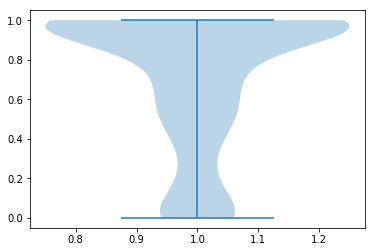

In [15]:
fig, axs = plt.subplots(1, 1)
axs.violinplot(logistic_probabilities)
print(np.mean(logistic_probabilities))
plt.show()

In [ ]:
ks = list(np.logspace(-3, 3, num=50))
probs = []
for k in ks:
    prob = test_noise_model(k)
    probs.append(prob)
fig, axs = plt.subplots(1, 1)
axs.line(ks, probs)
plt.show()

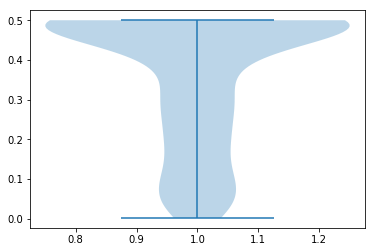

In [107]:
diff_logistic_probabilities = np.abs(np.array(logistic_probabilities) - 0.5)
fig, axs = plt.subplots(1, 1)
axs.violinplot(diff_logistic_probabilities)
plt.show()

Calculate the correlation between the ground truth probability and the logitic response probability.

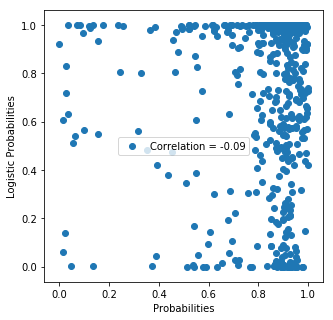

In [108]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.scatter(
    probabilities,
    logistic_probabilities,
    label=f'Correlation = {np.round(np.corrcoef(diff_probabilities, diff_logistic_probabilities)[0,1], 2)}'
)
axs.set_xlabel("Probabilities")
axs.set_ylabel("Logistic Probabilities")
plt.legend()
plt.show()

## Construct and Test a Noise Model

In [32]:
from enum import Enum
"""
    Enum of noise constant types
"""
class KNormalizationType(Enum):
    CONSTANT = 0
    NORMALIZED = 1
    DECAYING = 2
    

def pair2hyperplane(positive_z, negative_z, predicted_certainty):
    positive_z = positive_z.detach().cpu().numpy().squeeze()
    negative_z = negative_z.detach().cpu().numpy().squeeze()
    A_emb = 2*(positive_z - negative_z)
    if np.linalg.norm(A_emb) == 0:
        A_emb = np.ones_like(positive_z)*0.000001
    tau_emb = (np.linalg.norm(positive_z)**2 - np.linalg.norm(negative_z)**2)
    # scale tau_emb by predicted_certainty
    tau_emb *= predicted_certainty
    A_emb *= predicted_certainty
    """
    if normalization is KNormalizationType.CONSTANT:
        pass
    elif normalization is KNormalizationType.NORMALIZED:
        A_mag = np.linalg.norm(A_emb)
        A_emb = A_emb / A_mag
        tau_emb = tau_emb / A_mag
    elif normalization is KNormalizationType.DECAYING:
        A_mag = np.linalg.norm(A_emb)
        A_emb = A_emb * np.exp(-A_mag)
        tau_emb = tau_emb * np.exp(-A_mag)
    """
    return (A_emb, tau_emb)

def calculate_logistic_probability(anchor, positive, negative, k=1.0):
    anchor_mean, anchor_logvar = anchor
    positive_mean, positive_logvar = positive
    negative_mean, negative_logvar = negative
    def logistic_function(val):
        return 1 / (1 + np.exp(-val))
    
    # compute the predicted_certainty
    predicted_certainty = compute_predicted_certainty((anchor, positive, negative, 0))
    
    A_emb, tau_emb = pair2hyperplane(positive_mean, negative_mean, predicted_certainty=1)
    anchor_mean = anchor_mean.detach().cpu().numpy().squeeze()
    probability = logistic_function(k * predicted_certainty**0.5 *
        (np.dot(A_emb, anchor_mean) - tau_emb)
    )
    return probability

In [33]:

def test_noise_model(k):
    probs = []
    for triplet in triplets:
        anchor, positive, negative, _ = triplet
        probability = calculate_logistic_probability(anchor, positive, negative, k=k)
        probs.append(probability)
    probabilities = np.mean(probs)
    return probabilities

100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


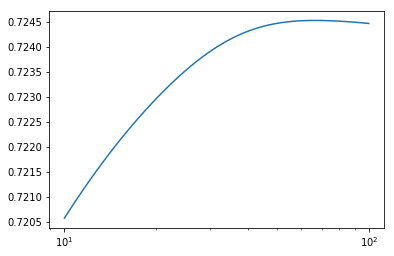

In [35]:
ks = list(np.logspace(1, 2, num=50))
probs = []
for k in tqdm(ks):
    prob = test_noise_model(k)
    probs.append(prob)

fig, axs = plt.subplots(1, 1)
axs.plot(ks, probs)
axs.set_xscale("log")
plt.show()
    

## Run and Analyze Some Localization Runs. 